<a href="https://colab.research.google.com/github/hyeonjun/boostcourse_tensorflow/blob/master/lab_12_4_many_to_many_bidirectional_keras_eager.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 12-4 Many to Many variable bidirectional

simple pos-tagger training
- many to many
- variable input sequence length
- bi-directional

RNN을 단방향 many to many 방식으로 활용할 때 각각의 토큰을 RNN이 읽을 때 정보의 불균형이 존재한다.

예를 들어 RNN이 시퀀스의 첫 번째 토큰을 읽었을 때 첫 번째 토큰에 대한 hidden states에는 정보가 1만큼 저장되어 있고 이 1을 기반으로 출력을 낸다. 두 번째 토큰을 읽었을 때는 앞의 hidden states를 받고 두 번째 시점에 토큰을 받아 처리한 결과도 같이 보기 때문에 두 개의 정보를 가지고 출력을 낸다.

bidirectional RNN은 위의 문제점을 해결할 수 있다. 시퀀스를 순서대로 읽는 forward RNN과 시퀀스를 역으로 읽는 backward RNN을 둔다. 

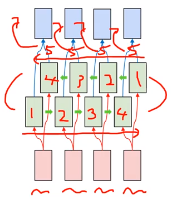

예를 들어 forward RNN의 경우 첫번째 토큰을 읽었을때 hidden states에 저장되는 정보는 1이고, 두 번째는 2, 세 번째는 3, 네 번째는 4라고 했을 때, backward RNN은 먼저 네번째 토큰을 읽었을 때 hidden states가 가지고 있는 정보는 1, 다음은 2, 3, 4가 된다.
그래서 이 두 가지 정보를 합치기 때문에 모든 토큰을 읽을때 마다 5개의 정보를 가지고 출력을 낼 수 있다.

# What is "bidirectional"?

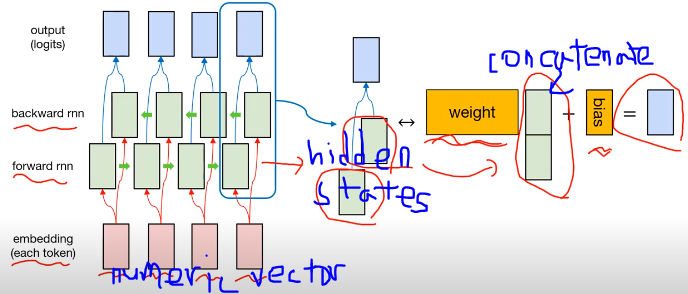

어떠한 시퀀스를 tokenization을 한 후 embedding layer를 활용하여 각각의 토큰을 numeric vector로 변환을 합니다.

이렇게 변환된 토큰을 forward RNN과 backword RNN이 읽고 각각의 RNN의 hidden states를 합칩니다. 즉 forward RNN의 hidden states와 backward RNN의 hidden states를 concatenate 하는 방식으로 새로운 벡터를 생성하고 어떤 weight와 bias를 활용하여 목적에 맞게 벡터를 생성, 모델링을 하는 구조입니다.

여기서  weight와 bias는 모든 토큰의 hidden states에 대해서 동일하게 적용된다.

In [ ]:
# setup
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential, Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pprint import pprint
%matplotlib inline

In [ ]:
# Preparing dataset
# example data
sentences = [['I', 'feel', 'hungry'],
     ['tensorflow', 'is', 'very', 'difficult'],
     ['tensorflow', 'is', 'a', 'framework', 'for', 'deep', 'learning'],
     ['tensorflow', 'is', 'very', 'fast', 'changing']]
pos = [['pronoun', 'verb', 'adjective'],
     ['noun', 'verb', 'adverb', 'adjective'],
     ['noun', 'verb', 'determiner', 'noun', 'preposition', 'adjective', 'noun'],
     ['noun', 'verb', 'adverb', 'adjective', 'verb']]

In [ ]:
# Prepocessing dataset
# creating a token dictionary for word
word_list = sum(sentences,[])
word_list = sorted(set(word_list))
word_list = ['<pad>']+word_list

word2idx = {word : idx for idx, word in enumerate(word_list)}
idx2word = {idx: word for idx, word in enumerate(word_list)}
print(word2idx)
print(idx2word)
print(len(idx2word))

{'<pad>': 0, 'I': 1, 'a': 2, 'changing': 3, 'deep': 4, 'difficult': 5, 'fast': 6, 'feel': 7, 'for': 8, 'framework': 9, 'hungry': 10, 'is': 11, 'learning': 12, 'tensorflow': 13, 'very': 14}
{0: '<pad>', 1: 'I', 2: 'a', 3: 'changing', 4: 'deep', 5: 'difficult', 6: 'fast', 7: 'feel', 8: 'for', 9: 'framework', 10: 'hungry', 11: 'is', 12: 'learning', 13: 'tensorflow', 14: 'very'}
15


In [ ]:

# creating a token dictionary for part of speech
pos_list = sum(pos, [])
pos_list = sorted(set(pos_list))
pos_list = ['<pad>'] + pos_list
pos2idx = {pos : idx for idx, pos in enumerate(pos_list)}
idx2pos = {idx : pos for idx, pos in enumerate(pos_list)}

print(pos2idx)
print(idx2pos)
print(len(pos2idx))

{'<pad>': 0, 'adjective': 1, 'adverb': 2, 'determiner': 3, 'noun': 4, 'preposition': 5, 'pronoun': 6, 'verb': 7}
{0: '<pad>', 1: 'adjective', 2: 'adverb', 3: 'determiner', 4: 'noun', 5: 'preposition', 6: 'pronoun', 7: 'verb'}
8


In [ ]:
# converting sequence of tokens to sequence of indices
max_sequence = 10
x_data = list(map(lambda sentence : [word2idx.get(token) for token in sentence], sentences))
y_data = list(map(lambda sentence : [pos2idx.get(token) for token in sentence], pos))
print(x_data)
print(y_data)

# padding the seqeunce of indices
x_data = pad_sequences(sequences=x_data, maxlen=max_sequence, padding='post')
x_data_mask = ((x_data != 0) * 1).astype(np.float32)
x_data_len = list(map(lambda sentence : len(sentence), sentences))
print(x_data)
print(x_data_mask)
print(x_data_len)

y_data = pad_sequences(sequences=y_data, maxlen=max_sequence, padding='post')
print(y_data)

[[1, 7, 10], [13, 11, 14, 5], [13, 11, 2, 9, 8, 4, 12], [13, 11, 14, 6, 3]]
[[6, 7, 1], [4, 7, 2, 1], [4, 7, 3, 4, 5, 1, 4], [4, 7, 2, 1, 7]]
[[ 1  7 10  0  0  0  0  0  0  0]
 [13 11 14  5  0  0  0  0  0  0]
 [13 11  2  9  8  4 12  0  0  0]
 [13 11 14  6  3  0  0  0  0  0]]
[[1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]]
[3, 4, 7, 5]
[[6 7 1 0 0 0 0 0 0 0]
 [4 7 2 1 0 0 0 0 0 0]
 [4 7 3 4 5 1 4 0 0 0]
 [4 7 2 1 7 0 0 0 0 0]]


In [ ]:
# Creating model
# creating bidirectional RNN for "many to many" sequence tagging
num_classes = len(pos2idx)
hidden_dim = 10

input_dim = len(word2idx)
output_dim = len(word2idx)
one_hot = np.eye(len(word2idx))

model = Sequential()
model.add(layers.InputLayer(input_shape=(max_sequence,)))
model.add(layers.Embedding(input_dim=input_dim, output_dim=output_dim, mask_zero=True,
                           trainable=False, input_length=max_sequence, embeddings_initializer=keras.initializers.Constant(one_hot)))
# layers.Bidirectional와 SimpleRNN을 사용하여 Bidirectional RNN 모델링
model.add(layers.Bidirectional(keras.layers.SimpleRNN(units=hidden_dim, return_sequences=True)))
# TimeDistributed와 Dense를 이용하여 매 토큰마다 품사가 무엇인지 classification을 하는 형태.
model.add(layers.TimeDistributed(keras.layers.Dense(units=num_classes)))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 15)            225       
_________________________________________________________________
bidirectional (Bidirectional (None, 10, 20)            520       
_________________________________________________________________
time_distributed (TimeDistri (None, 10, 8)             168       
Total params: 913
Trainable params: 688
Non-trainable params: 225
_________________________________________________________________


In [ ]:
# Training model
# creating loss function
def loss_fn(model, x, y, x_len, max_sequence):
  masking = tf.sequence_mask(x_len, maxlen=max_sequence, dtype=tf.float32)
  valid_time_step=tf.cast(x_len,dtype=tf.float32)
  sequence_loss = tf.keras.losses.sparse_categorical_crossentropy(
      y_true=y, y_pred=model(x), from_logits=True) * masking
  sequence_loss = tf.reduce_sum(sequence_loss, axis=-1)/ valid_time_step
  sequence_loss = tf.reduce_mean(sequence_loss)
  return sequence_loss

# creating and optimizer
lr = 0.1
epochs = 30
batch_size = 30
opt = tf.keras.optimizers.Adam(learning_rate=lr)

In [ ]:
# generating data pipeline
tr_dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data, x_data_len))
tr_dataset = tr_dataset.shuffle(buffer_size=4)
tr_dataset = tr_dataset.batch(batch_size=2)
print(tr_dataset)

<BatchDataset shapes: ((None, 10), (None, 10), (None,)), types: (tf.int32, tf.int32, tf.int32)>


In [ ]:
# training
tr_loss_list = []
for epoch in range(epochs):
  avg_tr_loss = 0
  tr_step = 0

  for x_mb, y_mb, x_mb_len in tr_dataset:
    with tf.GradientTape() as tape:
      tr_loss = loss_fn(model, x=x_mb, y=y_mb, x_len=x_mb_len, max_sequence=max_sequence)
    grads = tape.gradient(target=tr_loss, sources=model.variables)
    opt.apply_gradients(grads_and_vars=zip(grads, model.variables))
    avg_tr_loss += tr_loss
    tr_step += 1
  else:
    avg_tr_loss /= tr_step
    tr_loss_list.append(avg_tr_loss)
  if (epoch +1) % 5 == 0:
    print('epoch : {:3}, tr_loss : {:.10f}'.format(epoch+1, avg_tr_loss))

epoch :   5, tr_loss : 0.0121412054
epoch :  10, tr_loss : 0.0006014219
epoch :  15, tr_loss : 0.0002276730
epoch :  20, tr_loss : 0.0001004987
epoch :  25, tr_loss : 0.0000637869
epoch :  30, tr_loss : 0.0000504692


In [ ]:
# Checking performance
yhat = model.predict(x_data)
yhat = np.argmax(yhat, axis=-1) * x_data_mask

pprint(list(map(lambda row : [idx2pos.get(elm) for elm in row], yhat.astype(np.int32).tolist())), width=120)
pprint(pos)

[['pronoun', 'verb', 'adjective', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'],
 ['noun', 'verb', 'adverb', 'adjective', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'],
 ['noun', 'verb', 'determiner', 'noun', 'preposition', 'adjective', 'noun', '<pad>', '<pad>', '<pad>'],
 ['noun', 'verb', 'adverb', 'adjective', 'verb', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']]
[['pronoun', 'verb', 'adjective'],
 ['noun', 'verb', 'adverb', 'adjective'],
 ['noun', 'verb', 'determiner', 'noun', 'preposition', 'adjective', 'noun'],
 ['noun', 'verb', 'adverb', 'adjective', 'verb']]


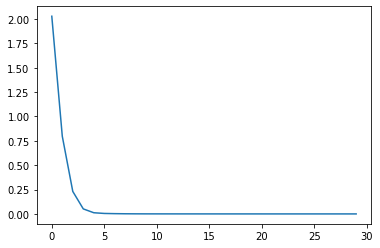

In [ ]:
plt.plot(tr_loss_list)